In [5]:
# Importing necessary libraries
import pandas as pd                  # For data manipulation
import numpy as np                   # For numerical operations
import matplotlib.pyplot as plt       # For plotting graphs
import seaborn as sns                # For statistical plots
import re                             # For text cleaning
import nltk                           # For text processing
from nltk.corpus import stopwords     # For removing stopwords
from nltk.stem import WordNetLemmatizer # For lemmatization
from sklearn.model_selection import train_test_split # For splitting the data
from sklearn.feature_extraction.text import TfidfVectorizer # For text vectorization
from sklearn.svm import SVC          # Support Vector Machine
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # Evaluation metrics
from sklearn.metrics import classification_report # To generate a complete classification report
import nltk
from nltk.tokenize import word_tokenize # For tokenizing text
from sklearn.metrics import confusion_matrix, roc_curve, auc
from wordcloud import WordCloud
import gensim.downloader as api
from gensim.models import KeyedVectors
import os

lemmatizer = WordNetLemmatizer()
# Download the NLTK resources (you might need to run this once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ouali\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ouali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ouali\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ouali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

First few rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Missing values in the dataset:
review       0
sentiment    0
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


C:\Users\ouali\AppData\Local\Temp\ipykernel_676\1758771257.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='coolwarm')


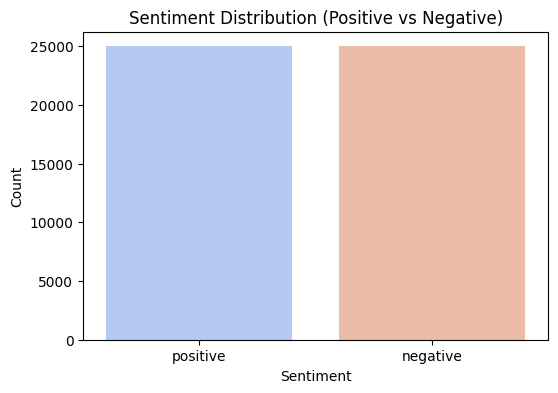

In [6]:
# Load the dataset
file_path="IMDB Dataset.csv"
# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to check structure
print("First few rows of the dataset:")
print(df.head())

# Check for missing values in the dataset
print("\nMissing values in the dataset:")
print(df.isnull().sum())

# Get the data types of the columns to ensure everything is loaded correctly
print("\nDataset info:")
print(df.info())
# 1. Sentiment Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, palette='coolwarm')
plt.title('Sentiment Distribution (Positive vs Negative)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [7]:
# Enhanced Text Cleaning Function with Negation and Sarcasm Handling
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags (this includes <br />, <p>, etc.)
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Enhanced text cleaning for sentiment analysis that preserves negations and sarcasm markers
def clean_text_for_analysis(text):
    # Convert to lowercase
    text = text.lower()
    
    # Replace negations with special tokens
    negation_patterns = [
        (r"n't\s", " not "),  # don't, won't, etc.
        (r"not\s", " NOT_"),  # preserve 'not' with following word
        (r"no\s", " NO_"),    # preserve 'no' with following word
        (r"never\s", " NEVER_")  # preserve 'never' with following word
    ]
    
    for pattern, replacement in negation_patterns:
        text = re.sub(pattern, replacement, text)
    
    # Mark potential sarcasm indicators
    sarcasm_patterns = [
        (r'\s*[!]+\s*', ' EXCL '),  # Multiple exclamation marks
        (r'\s*[?!]+\s*', ' SARCASM '),  # Question + exclamation
        (r'\"(.+?)\"', ' QUOTE \\1 QUOTE '),  # Quotation marks
        (r'\s*lol\s*', ' LOL '),  # Laughing indicators
        (r'\s*haha+\s*', ' LAUGH '),
        (r'\s*right+\s*[.?!]', ' SARC_RIGHT ')  # "right..." pattern
    ]
    
    for pattern, replacement in sarcasm_patterns:
        text = re.sub(pattern, replacement, text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Preserve emoticons (simple ones)
    text = re.sub(r':-?\)', ' HAPPY_EMOTICON ', text)
    text = re.sub(r':-?\(', ' SAD_EMOTICON ', text)
    
    # Remove special characters but keep underscore for token markers
    text = re.sub(r'[^a-zA-Z\s_]', ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [8]:
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    
    # Keep negation markers and sarcasm indicators
    special_tokens = ['NOT_', 'NO_', 'NEVER_', 'EXCL', 'SARCASM', 'QUOTE', 'LOL', 'LAUGH', 
                     'SARC_RIGHT', 'HAPPY_EMOTICON', 'SAD_EMOTICON']
    
    # Filter out stopwords but keep special tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = []
    
    for token in tokens:
        if any(token.startswith(special) for special in special_tokens):
            # Keep special tokens as is
            filtered_tokens.append(token)
        elif token not in stop_words:
            # Lemmatize and add regular tokens
            filtered_tokens.append(lemmatizer.lemmatize(token))
    
    return filtered_tokens

# Apply the two different text cleaning methods
df['cleaned_review'] = df['review'].apply(clean_text)  # Basic cleaning for word clouds
df['analysis_review'] = df['review'].apply(clean_text_for_analysis)  # Enhanced cleaning for sentiment analysis

# Apply tokenization and lemmatization to the analysis reviews
df['processed_review'] = df['analysis_review'].apply(tokenize_and_lemmatize)

# Display the first few rows to see the cleaned and processed reviews
df[['review', 'cleaned_review', 'processed_review']].head()

,review,cleaned_review,processed_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, reviewer, mentioned, watching, oz, episo..."
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,basically there s a family where a little boy ...,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei s love in the time of money is a...,"[petter, mattei, QUOTE, love, time, money, QUO..."


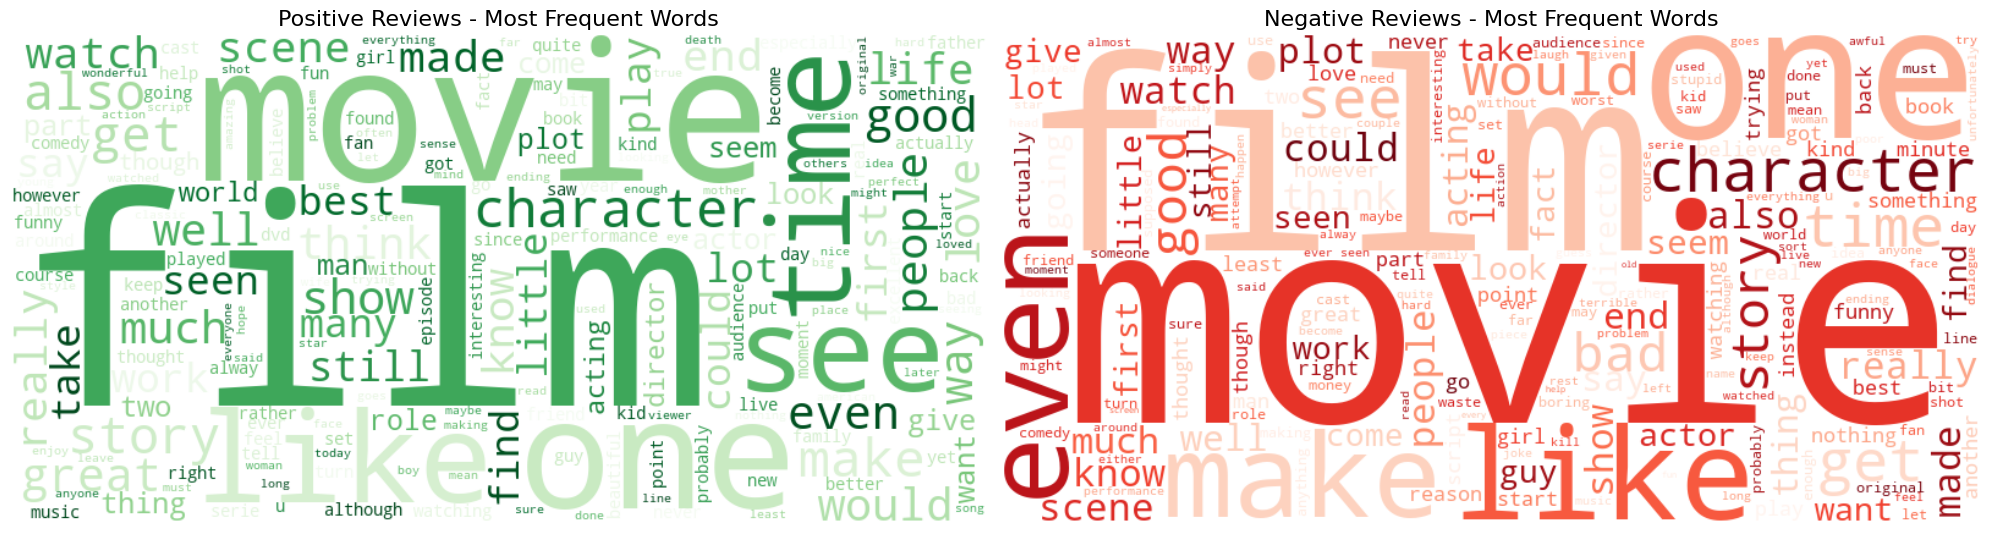

In [9]:
df['clean_for_wordcloud'] = df['review'].apply(clean_text)  # Use the basic cleaner without special tokens

# Create separate word clouds for positive and negative reviews
positive_text = ' '.join(df[df['sentiment'] == 'positive']['clean_for_wordcloud'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['clean_for_wordcloud'])

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Generate positive word cloud
positive_wordcloud = WordCloud(
    stopwords=stopwords.words('english'),
    background_color='white',
    max_words=200,
    colormap='Greens',
    width=800,
    height=400
).generate(positive_text)

# Generate negative word cloud
negative_wordcloud = WordCloud(
    stopwords=stopwords.words('english'),
    background_color='white',
    max_words=200,
    colormap='Reds',
    width=800,
    height=400
).generate(negative_text)

# Display the word clouds
ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.set_title('Positive Reviews - Most Frequent Words', fontsize=16)
ax1.axis('off')

ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.set_title('Negative Reviews - Most Frequent Words', fontsize=16)
ax2.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Load GloVe embeddings
print("Loading GloVe word embeddings. This may take a few minutes if downloading for the first time...")
glove_model = api.load("glove-wiki-gigaword-300")
print("GloVe embeddings loaded successfully!")

def get_document_vector(tokens, embedding_model, vector_size=300):
    """
    Create document vectors by averaging word vectors
    """
    # Initialize an empty array for the document vector
    doc_vector = np.zeros(vector_size)
    count = 0
    
    # Sum up vectors for each word in the document
    for word in tokens:
        if word in embedding_model:
            doc_vector += embedding_model[word]
            count += 1
    
    # Average the vectors
    if count > 0:
        doc_vector /= count
    else:
        # For empty documents or those with no words in the embedding model,
        # return a small random vector instead of zeros to avoid issues with ML algorithms
        doc_vector = np.random.normal(0, 0.01, vector_size)
    
    return doc_vector

# Convert processed reviews to document vectors using GloVe embeddings
print("Converting reviews to document vectors using GloVe embeddings...")
X_glove = np.zeros((len(df), 300))
for i, tokens in enumerate(df['processed_review']):
    if i % 5000 == 0:  # Print progress
        print(f"Processing review {i}/{len(df)}")
    X_glove[i] = get_document_vector(tokens, glove_model)
print("Vectorization complete!")

Loading GloVe word embeddings. This may take a few minutes if downloading for the first time...
[==================================================] 100.0% 376.1/376.1MB downloaded
GloVe embeddings loaded successfully!
Converting reviews to document vectors using GloVe embeddings...
Processing review 0/50000
Processing review 5000/50000
Processing review 10000/50000
Processing review 15000/50000
Processing review 20000/50000
Processing review 25000/50000
Processing review 30000/50000
Processing review 35000/50000
Processing review 40000/50000
Processing review 45000/50000
Vectorization complete!


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, df['sentiment'], test_size=0.2, random_state=42)

print("Training and testing sets created.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Initialize the SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Train the SVM model
print("Training SVM model...")
svm_model.fit(X_train, y_train)
print("SVM model trained successfully!")

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Get prediction probabilities for confidence scores
y_pred_proba = svm_model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='positive')
recall = recall_score(y_test, y_pred, pos_label='positive')
f1 = f1_score(y_test, y_pred, pos_label='positive')

# Print evaluation metrics
print(f"SVM with GloVe Embeddings - Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training and testing sets created.
Training set shape: (40000, 300)
Testing set shape: (10000, 300)
Training SVM model...
SVM model trained successfully!
SVM with GloVe Embeddings - Evaluation Metrics:
Accuracy: 0.8323
Precision: 0.8322
Recall: 0.8357
F1-Score: 0.8339

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.83      0.83      4961
    positive       0.83      0.84      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [12]:
# Initialize models
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
naive_bayes_model = MultinomialNB()
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the models
print("Training additional models...")
log_reg_model.fit(X_train, y_train)
# Note: MultinomialNB expects non-negative features, so it's not suitable for word embeddings
# We'll skip Naive Bayes for now
random_forest_model.fit(X_train, y_train)
print("Additional models trained successfully!")

# Make predictions
y_pred_log_reg = log_reg_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)

# Get prediction probabilities for each model
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)
y_pred_proba_rf = random_forest_model.predict_proba(X_test)

# Evaluate all models
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='positive')
    recall = recall_score(y_true, y_pred, pos_label='positive')
    f1 = f1_score(y_true, y_pred, pos_label='positive')
    return accuracy, precision, recall, f1

# Evaluate each model
svm_metrics = evaluate_model(y_test, y_pred)
log_reg_metrics = evaluate_model(y_test, y_pred_log_reg)
rf_metrics = evaluate_model(y_test, y_pred_rf)

# Display results
models = ['SVM', 'Logistic Regression', 'Random Forest']
metrics = [svm_metrics, log_reg_metrics, rf_metrics]

for model, metric in zip(models, metrics):
    print(f"\n{model} with GloVe Embeddings - Metrics:")
    print(f"Accuracy: {metric[0]:.4f}")
    print(f"Precision: {metric[1]:.4f}")
    print(f"Recall: {metric[2]:.4f}")
    print(f"F1-Score: {metric[3]:.4f}")

Training additional models...
Additional models trained successfully!

SVM with GloVe Embeddings - Metrics:
Accuracy: 0.8323
Precision: 0.8322
Recall: 0.8357
F1-Score: 0.8339

Logistic Regression with GloVe Embeddings - Metrics:
Accuracy: 0.8306
Precision: 0.8311
Recall: 0.8331
F1-Score: 0.8321

Random Forest with GloVe Embeddings - Metrics:
Accuracy: 0.7902
Precision: 0.7850
Recall: 0.8037
F1-Score: 0.7943


<Figure size 1200x800 with 0 Axes>

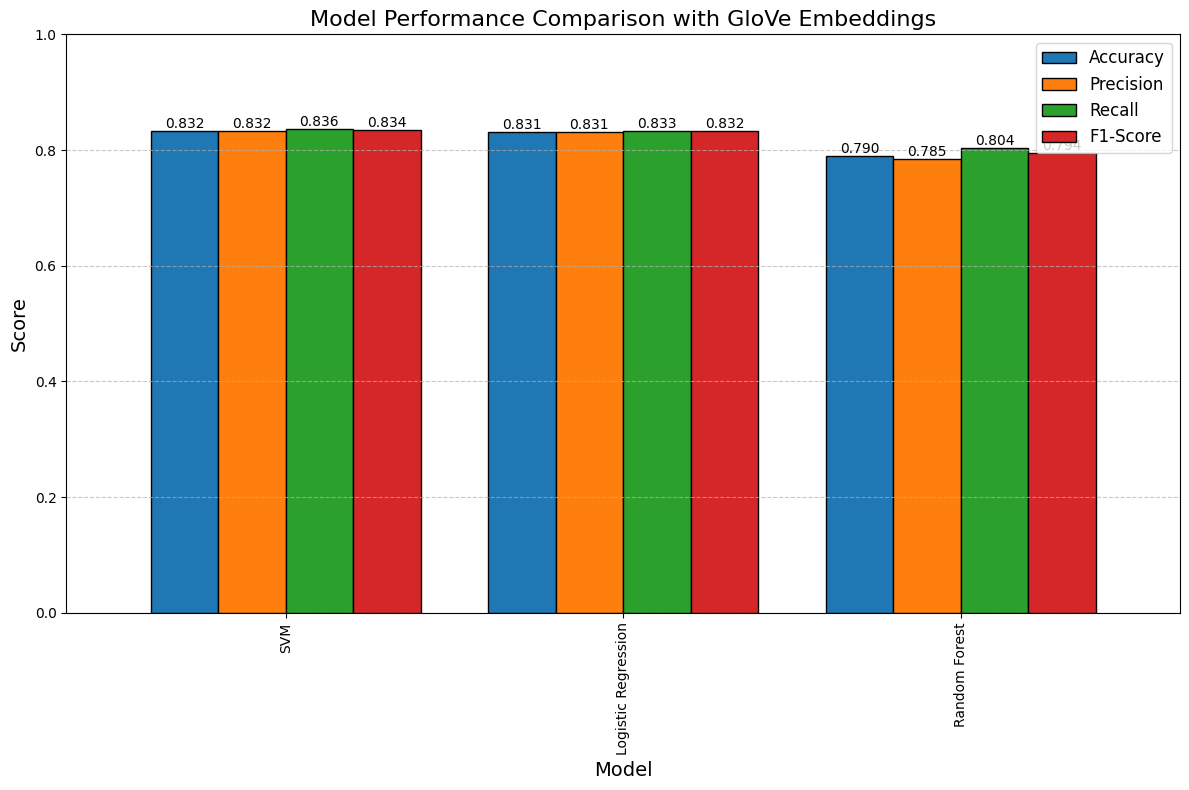

In [13]:
# Enhanced Model Performance Comparison (Bar Plot)
model_names = ['SVM', 'Logistic Regression', 'Random Forest']
accuracy_scores = [svm_metrics[0], log_reg_metrics[0], rf_metrics[0]]
precision_scores = [svm_metrics[1], log_reg_metrics[1], rf_metrics[1]]
recall_scores = [svm_metrics[2], log_reg_metrics[2], rf_metrics[2]]
f1_scores = [svm_metrics[3], log_reg_metrics[3], rf_metrics[3]]

# Create a dataframe for plotting
model_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores
})

# Plot the results as bar charts with improved styling
plt.figure(figsize=(12, 8))
ax = model_comparison_df.set_index('Model').plot(
    kind='bar', 
    figsize=(12, 8),
    width=0.8,
    edgecolor='black',
    linewidth=1
)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=10)

plt.title('Model Performance Comparison with GloVe Embeddings', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylim(0, 1.0)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

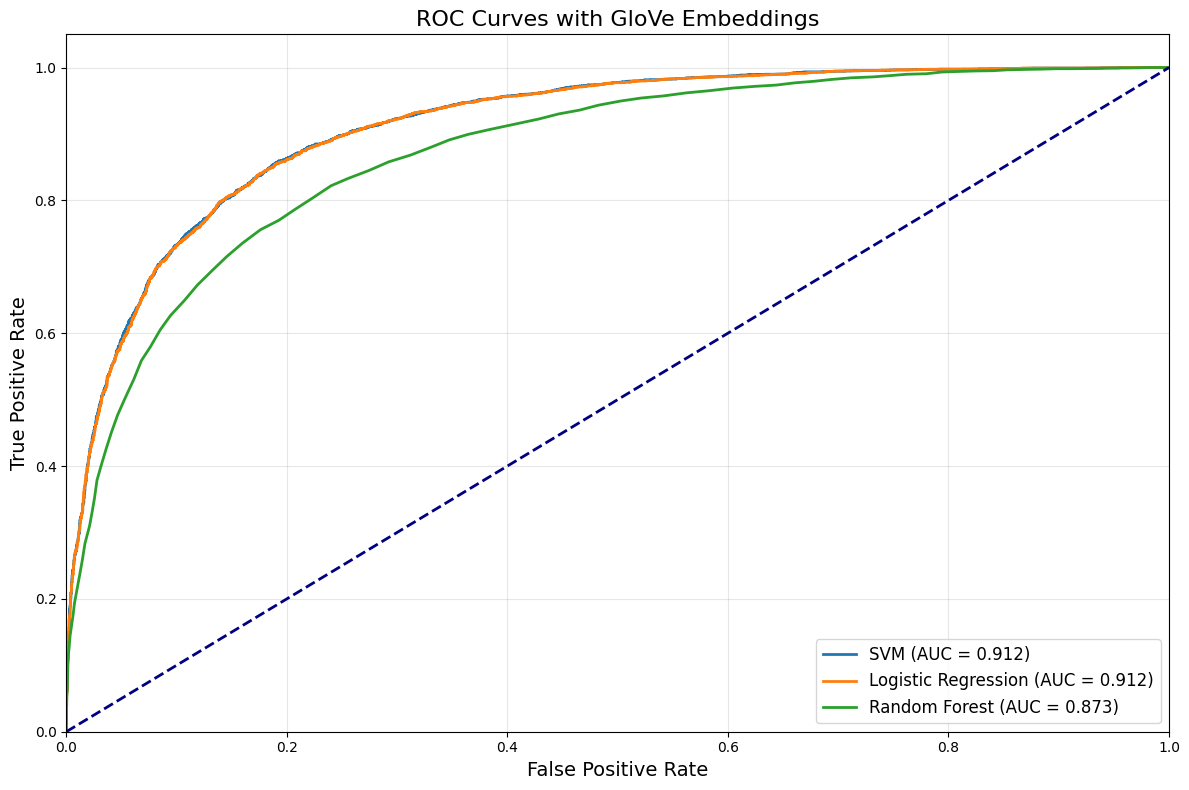

In [14]:
plt.figure(figsize=(12, 8))

# Store model data for ROC curves
model_data = {
    'SVM': {'model': svm_model, 'pred_proba': y_pred_proba},
    'Logistic Regression': {'model': log_reg_model, 'pred_proba': y_pred_proba_log_reg},
    'Random Forest': {'model': random_forest_model, 'pred_proba': y_pred_proba_rf}
}

for model_name, data in model_data.items():
    # Get binary class probabilities (positive class)
    y_score = data['pred_proba'][:, 1]
    
    # Convert labels to binary (1 for positive, 0 for negative)
    y_binary = (y_test == 'positive').astype(int)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot attributes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves with GloVe Embeddings', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

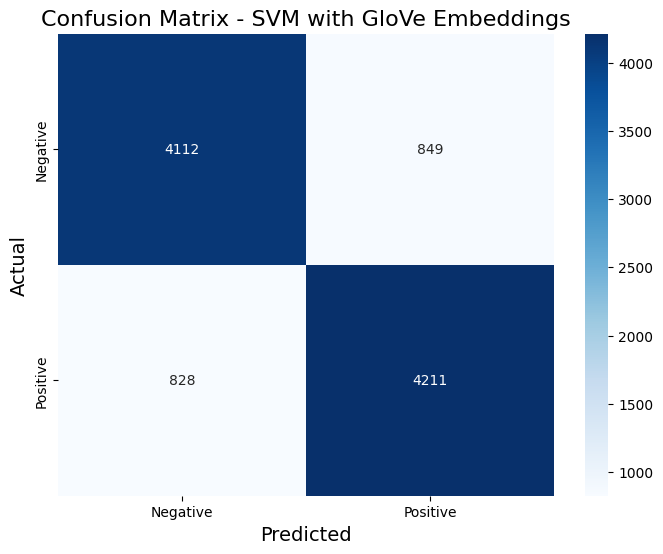

In [15]:
accuracies = [svm_metrics[0], log_reg_metrics[0], rf_metrics[0]]
best_model_index = accuracies.index(max(accuracies))
best_model_name = model_names[best_model_index]

# Get predictions from the best model
if best_model_name == 'SVM':
    best_predictions = y_pred
elif best_model_name == 'Logistic Regression':
    best_predictions = y_pred_log_reg
else:
    best_predictions = y_pred_rf

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, best_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title(f'Confusion Matrix - {best_model_name} with GloVe Embeddings', fontsize=16)
plt.show()

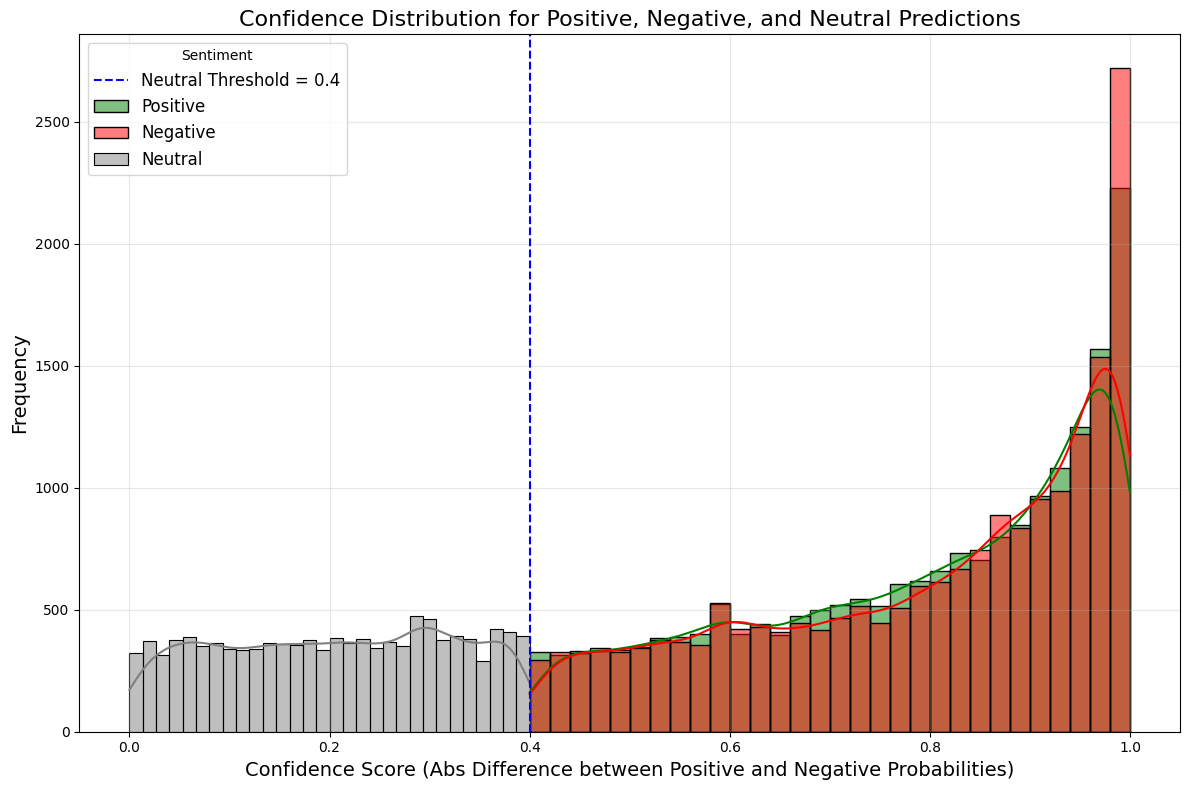

In [16]:
def get_document_vector(tokens, embedding_model, vector_size=300):
    """
    Create document vectors by averaging word vectors.
    """
    # Initialize an empty array for the document vector
    doc_vector = np.zeros(vector_size)
    count = 0
    
    # Sum up vectors for each word in the document
    for word in tokens:
        if word in embedding_model:
            doc_vector += embedding_model[word]
            count += 1
    
    # Average the vectors
    if count > 0:
        doc_vector /= count
    else:
        # For empty documents or those with no words in the embedding model,
        # return a small random vector instead of zeros to avoid issues with ML algorithms
        doc_vector = np.random.normal(0, 0.01, vector_size)
    
    return doc_vector

# Confidence plot function for neutral class
def plot_confidence_for_neutral_class(model, embedding_model, df, confidence_threshold=0.4, vector_size=300):
    """
    Generate a confidence plot for positive, negative, and neutral classes using GloVe embeddings and SVM model.
    """
    confidence_scores = []
    words_for_confidence = []
    
    # Loop through the processed reviews and get the confidence score for each review
    for idx, review in enumerate(df['processed_review']):
        # Convert processed review to GloVe embeddings (document vector)
        review_vector = get_document_vector(review, embedding_model, vector_size).reshape(1, -1)
        
        # Get prediction probabilities for the review
        probabilities = model.predict_proba(review_vector)[0]
        
        # Calculate the confidence score (absolute difference between positive and negative probabilities)
        confidence = abs(probabilities[1] - probabilities[0])
        
        # Define sentiment class based on confidence threshold
        if confidence < confidence_threshold:
            sentiment = 'Neutral'
        elif probabilities[1] > probabilities[0]:
            sentiment = 'Positive'
        else:
            sentiment = 'Negative'
        
        # Store the confidence score and sentiment
        confidence_scores.append(confidence)
        words_for_confidence.append(sentiment)

    # Create a DataFrame to store confidence scores and corresponding words
    confidence_df = pd.DataFrame({
        'Review Index': range(len(confidence_scores)),
        'Confidence': confidence_scores,
        'Sentiment': words_for_confidence
    })
    
    # Plotting the confidence distribution
    plt.figure(figsize=(12, 8))
    
    # Separate the reviews into positive, negative, and neutral
    sns.histplot(data=confidence_df[confidence_df['Sentiment'] == 'Positive'], 
                 x='Confidence', color='green', kde=True, label='Positive', bins=30)
    sns.histplot(data=confidence_df[confidence_df['Sentiment'] == 'Negative'], 
                 x='Confidence', color='red', kde=True, label='Negative', bins=30)
    sns.histplot(data=confidence_df[confidence_df['Sentiment'] == 'Neutral'], 
                 x='Confidence', color='gray', kde=True, label='Neutral', bins=30)
    
    # Add the threshold line to distinguish neutral from positive and negative
    plt.axvline(confidence_threshold, color='blue', linestyle='--', label=f'Neutral Threshold = {confidence_threshold}')
    
    # Add labels and title
    plt.title('Confidence Distribution for Positive, Negative, and Neutral Predictions', fontsize=16)
    plt.xlabel('Confidence Score (Abs Difference between Positive and Negative Probabilities)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(title='Sentiment', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage: Plot confidence for the neutral class
plot_confidence_for_neutral_class(svm_model, glove_model, df, confidence_threshold=0.4)

In [17]:
import joblib
joblib.dump(globals()[best_model_name.lower().replace(' ', '_') + '_model'], f'glove_embedding_{best_model_name.lower().replace(" ", "_")}_model.pkl')
print(f"Best model ({best_model_name} with GloVe embeddings) saved successfully!")

# Function for predicting sentiment with confidence level
def predict_sentiment_with_confidence(model, review, glove_model, confidence_threshold=0.4):
    """Predict sentiment with confidence-based neutral classification using GloVe embeddings"""
    # Clean and process the review
    cleaned_review = clean_text_for_analysis(review)
    processed_review = tokenize_and_lemmatize(cleaned_review)
    
    # Convert to document vector using GloVe
    review_vector = get_document_vector(processed_review, glove_model)
    review_vector = review_vector.reshape(1, -1)  # Reshape for prediction
    
    # Get prediction probabilities
    probabilities = model.predict_proba(review_vector)[0]
    
    # Get confidence score
    confidence = abs(probabilities[1] - probabilities[0])
    
    # Determine sentiment based on confidence
    if confidence < confidence_threshold:
        sentiment = "Neutral"
    elif probabilities[1] > probabilities[0]:
        sentiment = "Positive"
    else:
        sentiment = "Negative"
    
    return {
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': {
            'negative': probabilities[0],
            'positive': probabilities[1]
        }
    }

# Test the model with some example reviews
example_reviews = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "The movie was terrible, I hated it.",
    "The movie was abit of good and i had a mixed opinion about it. It had some good parts and some bad parts.",
    "I'm not sure if I liked it or not. It was different than the usual and i don't know if it was a positive reaction or bad one from me.",
    "Well i was a bit disappointed at the beginning of the movie i had very mixed feelings about it but since the story started to develop more and more and by the end i was kinda interested so i would say it was an okay movie"
]

# Get the best model for predictions
best_model = globals()[best_model_name.lower().replace(' ', '_') + '_model']

# Predict sentiment for each example
print("\nExample Predictions with GloVe Embeddings:")
for review in example_reviews:
    result = predict_sentiment_with_confidence(best_model, review, glove_model)
    print(f"\nReview: {review}")
    print(f"Predicted Sentiment: {result['sentiment']}")
    print(f"Confidence Score: {result['confidence']:.4f}")
    print(f"Probabilities: Negative: {result['probabilities']['negative']:.4f}, Positive: {result['probabilities']['positive']:.4f}")

Best model (SVM with GloVe embeddings) saved successfully!

Example Predictions with GloVe Embeddings:

Review: This movie was absolutely fantastic! I loved every minute of it.
Predicted Sentiment: Positive
Confidence Score: 0.9842
Probabilities: Negative: 0.0079, Positive: 0.9921

Review: The movie was terrible, I hated it.
Predicted Sentiment: Negative
Confidence Score: 0.9991
Probabilities: Negative: 0.9996, Positive: 0.0004

Review: The movie was abit of good and i had a mixed opinion about it. It had some good parts and some bad parts.
Predicted Sentiment: Neutral
Confidence Score: 0.0528
Probabilities: Negative: 0.5264, Positive: 0.4736

Review: I'm not sure if I liked it or not. It was different than the usual and i don't know if it was a positive reaction or bad one from me.
Predicted Sentiment: Positive
Confidence Score: 0.6046
Probabilities: Negative: 0.1977, Positive: 0.8023

Review: Well i was a bit disappointed at the beginning of the movie i had very mixed feelings about 